In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from math import sqrt

# from sklearn import preprocessing
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# import numpy as np
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.models import load_model, Model

# import datetime
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.optimizers import Adam
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from matplotlib import pyplot as plt

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, BatchNormalization
# from keras.layers.convolutional import Conv1D    
# from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPooling1D,Bidirectional

# from keras.callbacks import TensorBoard
# from keras.callbacks import ModelCheckpoint
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from tensorflow.keras.optimizers import SGD
# from matplotlib import pyplot

df_14, df_15, df_16, df_17, df_18, df_19, df_20 = [pd.read_csv(fr"../../../Taipei_{i}.csv") 
                                                   for i in range(14,21)]


# In[3]:


def get_X_and_Y(table, station_name = 'Banqiao'):
    table = table[table.SiteEngName =='Banqiao']
    features=table[['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5','RAINFALL', 'RH']]
    #print(f'The shape of the input table is {features.shape}')
    data = np.array(features.values.reshape((-1,10*1)))
    timestep=16
    x_build = []
    for i in range(data.shape[0] - timestep - timestep):
        x_build.append(data[i:i+timestep])
    train_x = np.array(x_build)
    #print(f'The shape of the input train_x is {train_x.shape}')


    data = np.array(table['PM2.5'].values.reshape((-1, 1)))
    y_build = []
    for i in range(timestep, data.shape[0] - timestep):
        y_build.append(data[i:i+timestep])
    train_y = np.array(y_build)
    print(f'The shape of the input train_y is {train_y.shape}')
    print('-'*50)
    return (train_x, train_y)

train14_x, train14_y = get_X_and_Y(df_14, station_name = 'Banqiao')
train15_x, train15_y = get_X_and_Y(df_15, station_name = 'Banqiao')
train16_x, train16_y = get_X_and_Y(df_16, station_name = 'Banqiao')
train17_x, train17_y = get_X_and_Y(df_17, station_name = 'Banqiao')
train18_x, train18_y = get_X_and_Y(df_18, station_name = 'Banqiao')
train19_x, train19_y = get_X_and_Y(df_19, station_name = 'Banqiao')
train20_x, train20_y = get_X_and_Y(df_20, station_name = 'Banqiao')


# In[16]:


train_X=np.concatenate((train14_x,train15_x,train16_x,train17_x,train18_x,train19_x),axis=0)
#print(train_X.shape)
train_y=np.concatenate((train14_y,train15_y,train16_y,train17_y,train18_y,train19_y),axis=0)
#print(train_y.shape)
test_X=train20_x;test_y=train20_y
#print(train20_x.shape,train20_y.shape)


from sklearn.model_selection import train_test_split
# create dataset
X, y = test_X,test_y

# split into train test sets
valid_x,test_x,valid_y,test_y = train_test_split(X, y, test_size=0.5)
print(valid_x.shape, valid_y.shape,test_x.shape, test_y.shape)

print("train_X.shape, train_y.shape, test_x.shape, test_y.shape") 
print(train_X.shape, train_y.shape, test_x.shape, test_y.shape) 

####################################
######################################

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, concatenate
from tensorflow.keras.models import Model

# Define the input layers
input1 = Input(shape=(train_X.shape[1], train_X.shape[2]))
x1 = Conv1D(filters=100, kernel_size=1, activation='relu')(input1)
x1 = MaxPooling1D(pool_size=1)(x1)
lstm1 = Bidirectional(LSTM(50, return_sequences=True))(x1)
output1 = Dense(50, activation='relu')(lstm1)
out=Dense(1, activation='relu')(output1)
###########################
model = Model(inputs=[input1], outputs=out)

model.compile(loss='mse',optimizer='adam',metrics=['mae'])

model.summary()

# # Compile the model
# model.compile(loss='mse',optimizer='adam',metrics=['mae'])

# # Print model summary
# model.summary()

The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input train_y is (8758, 1, 1)
--------------------------------------------------
The shape of the input train_y is (4322, 1, 1)
--------------------------------------------------
(2161, 1, 10) (2161, 1, 1) (2161, 1, 10) (2161, 1, 1)
train_X.shape, train_y.shape, test_x.shape, test_y.shape
(52548, 1, 10) (52548, 1, 1) (2161, 1, 10) (2161, 1, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import numpy as np
checkpoint_path = "Banqiao1ffv.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback   = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

#Train the model with the new callback
history = model.fit((train_X) ,
                    (train_y), 
                    validation_data=((valid_x),
                                    (valid_y)),
                    epochs =100, batch_size=19, verbose = 2, shuffle = True,
                    callbacks=[cp_callback])


# In[ ]:


model.load_weights(checkpoint_path)


# In[ ]:


scores = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', scores)
predict_ary = model.predict([test_x.astype("float")], batch_size = 190)
print (predict_ary.shape)
print (test_y.shape)
#print (X_valid.shape)
rmse_score20 = np.sqrt(np.mean(np.square(predict_ary - test_y.astype("float"))))
mae_score = np.mean(np.abs(predict_ary - test_y.astype("float")))
#mape_score = mean_absolute_percentage_error(y_valid_c.astype("float"),predict_ary)
#mae2 = mean_absolute_error(predict_ary, validation_Y[:-3])
print('this is rmse ',rmse_score20)
#print('this is mape ',mape_score)
print('this is mae ',mae_score)

y_pred_flat = predict_ary.reshape(-1)
y_true_flat = test_y.astype("float").reshape(-1)

# Calculate metrics
r2 = r2_score(y_true_flat, y_pred_flat)
mape = mean_absolute_percentage_error(y_true_flat, y_pred_flat)

# In[ ]:


Epoch 1/100
2766/2766 - 20s - loss: 28.4218 - mae: 3.5374 - val_loss: 22.1137 - val_mae: 3.2783 - 20s/epoch - 7ms/step
Epoch 2/100
2766/2766 - 8s - loss: 18.4693 - mae: 3.0883 - val_loss: 20.0518 - val_mae: 3.1669 - 8s/epoch - 3ms/step
Epoch 3/100
2766/2766 - 8s - loss: 16.9957 - mae: 2.9724 - val_loss: 18.2553 - val_mae: 2.9362 - 8s/epoch - 3ms/step
Epoch 4/100
2766/2766 - 8s - loss: 15.6744 - mae: 2.8486 - val_loss: 19.0651 - val_mae: 2.9926 - 8s/epoch - 3ms/step
Epoch 5/100
2766/2766 - 8s - loss: 15.0396 - mae: 2.7973 - val_loss: 17.9065 - val_mae: 2.9424 - 8s/epoch - 3ms/step
Epoch 6/100
2766/2766 - 8s - loss: 14.6944 - mae: 2.7672 - val_loss: 18.4790 - val_mae: 2.9948 - 8s/epoch - 3ms/step
Epoch 7/100
2766/2766 - 8s - loss: 14.5528 - mae: 2.7515 - val_loss: 18.9066 - val_mae: 2.9918 - 8s/epoch - 3ms/step
Epoch 8/100
2766/2766 - 8s - loss: 14.3488 - mae: 2.7348 - val_loss: 18.1521 - val_mae: 2.9160 - 8s/epoch - 3ms/step
Epoch 9/100
2766/2766 - 8s - loss: 14.2847 - mae: 2.7325 - val

Epoch 71/100
2766/2766 - 7s - loss: 13.4115 - mae: 2.6306 - val_loss: 17.9195 - val_mae: 2.8929 - 7s/epoch - 2ms/step
Test loss: [19.488454818725586, 3.034423589706421]
Test accuracy: [19.488454818725586, 3.034423589706421]
12/12 [==============================] - 1s 2ms/step
(2161, 1, 1)
(2161, 1, 1)
this is rmse  4.414573367001869
this is mae  3.0344242409366746


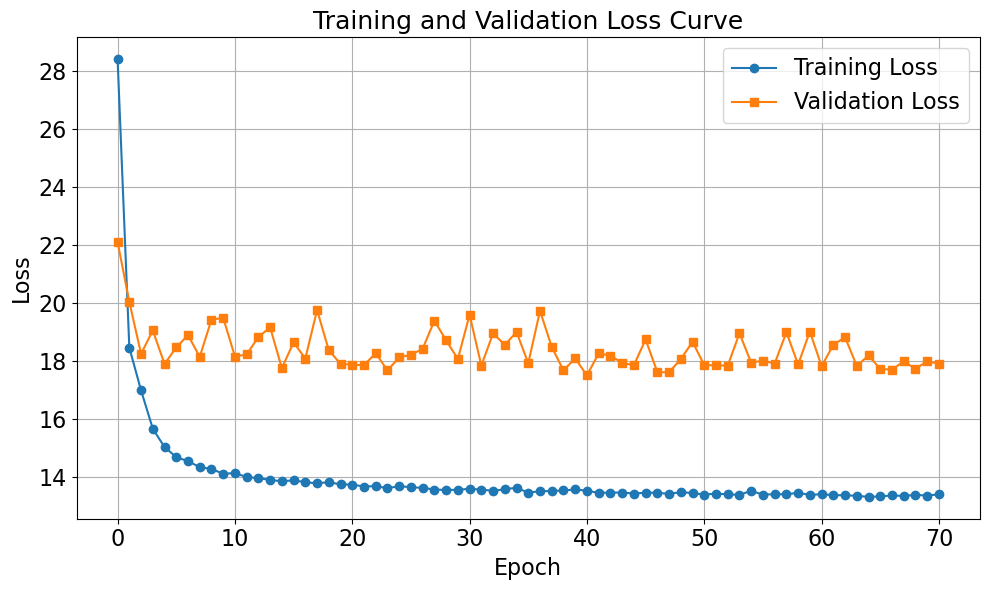

In [4]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.title('Training and Validation Loss Curve', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)

# Enlarged legend
plt.legend(fontsize=16)

# Enlarged tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


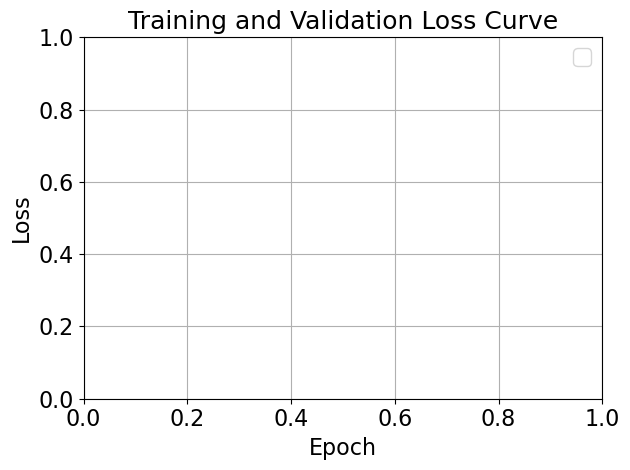

In [5]:

plt.title('Training and Validation Loss Curve', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)

# Enlarged legend
plt.legend(fontsize=16)

# Enlarged tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True)
plt.tight_layout()
plt.show()